In [1]:
import mujoco
import mediapy as media
from dm_control import mjcf
import numpy as np
from robot_descriptions.panda_mj_description import MJCF_PATH
from scripts.utils import update_actuator, ActuatorMotor

np.random.seed(0)

In [2]:
# load the model
mjcf_model = mjcf.from_path(MJCF_PATH)
# append the body to the end-effector
ee_body = mjcf_model.find("body", "hand")

ee_body

MJCF Element: <body name="hand" pos="0 0 0.107" quat="0.92387949999999996 0 0 -0.38268340000000001">...</body>

In [3]:
MJCF_PATH

'/home/simeon/.cache/robot_descriptions/mujoco_menagerie/franka_emika_panda/panda.xml'

In [4]:
# load_mass.add("inertial", mass=f"{M}", pos=f"{rc[0]} {rc[1]} {rc[2]}", diaginertia=f"{I} {I} {I}")

In [5]:
# old model
old_model = mujoco.MjModel.from_xml_path(MJCF_PATH)
old_data = mujoco.MjData(old_model)
body_offset = np.where(old_model.body_dofadr == 0)[0][0]

# create new body
rc = np.array([0., 0.1, 0.])
load_mass = ee_body.add("body", name="load_mass", pos=f"{rc[0]} {rc[1]} {rc[2]}")
load_mass.add(
    "geom", name="load_mass_geom", type="sphere", size="0.05", rgba="0.8 0.2 0.2 1"
)

M = 2.0
# R = 0.0001
I = 1e-3#M * rc[0]**2

load_mass.add("inertial", mass=f"{M}", pos=f"{rc[0]} {rc[1]} {rc[2]}", diaginertia=f"{1e-3} {1e-3} {1e-3}")



physics = mjcf.Physics.from_mjcf_model(mjcf_model)
sim_model = physics.model._model
sim_data = mujoco.MjData(sim_model)
renderer = mujoco.Renderer(sim_model, height=480, width=640)

""

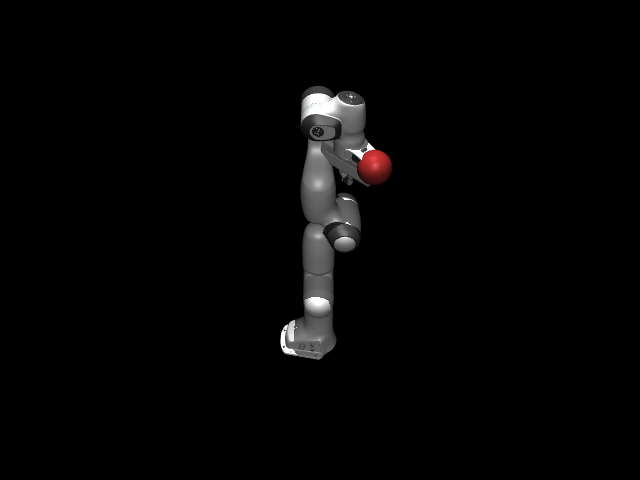

In [6]:
# Reset data, set initial pose.
mujoco.mj_resetData(sim_model, sim_data)

# Step the simulation.
mujoco.mj_step(sim_model, sim_data)

renderer.update_scene(sim_data)
media.show_image(renderer.render())

In [7]:
def staticload_joint_regressor(mj_model, mj_data, ee_id, active_joints = 7, body_offset = 0):

    accel = np.zeros(6)

    mujoco.mj_rnePostConstraint(mj_model, mj_data)
    mujoco.mj_objectAcceleration(mj_model, mj_data, 2, ee_id, accel, 1)
    rotation = mj_data.xmat[ee_id+body_offset].reshape(3, 3).copy()

    a1, a2, a3 = rotation.T @ np.array([0,0,9.81]) # accel[3:]

    static_load_regressor = np.array([[a1, 0, 0, 0],
                                      [a2, 0, 0, 0],
                                      [a3, 0, 0, 0],
                                      [0, 0, a3, -a2],
                                      [0, -a3, 0, a1],
                                      [0, a2, -a1, 0]])
    
    jac_lin = np.zeros((3, mj_model.nv))
    jac_rot = np.zeros((3, mj_model.nv))
    mujoco.mj_jacBody(mj_model, mj_data, jac_lin, jac_rot, ee_id + body_offset)
    ee_local_jacobian = np.vstack((rotation.T@jac_lin[:, :active_joints],
                                   rotation.T@jac_rot[:, :active_joints]))
    joint_regressor = ee_local_jacobian.T @ static_load_regressor
    
    return joint_regressor

In [8]:
for actuator_id in range(sim_model.nu):
    actuator = ActuatorMotor()
    update_actuator(sim_model, actuator_id, actuator)

# find limits except the last two fingers
lower, upper = np.zeros(sim_model.nq - 2), np.zeros(sim_model.nq - 2)
for jnt_idx in range(sim_model.nq - 2):
    lower[jnt_idx] = sim_model.joint(jnt_idx).range[0]
    upper[jnt_idx] = sim_model.joint(jnt_idx).range[1]

kp = 50
kd = 10
target_q = np.random.uniform(lower, upper)

frames = []
framerate = 25

phase_time = 5.0
num_of_phases = 50
phases = 0
old_data.time = 0 
sim_data.time = 0

# print(sim_model.nq)
load_joint_regressor = np.zeros(((sim_model.nq-2)*num_of_phases, 4))
load_joint_force = np.zeros(((sim_model.nq-2))*num_of_phases)
active_joints = (sim_model.nq-2)

while sim_data.time < num_of_phases*phase_time:
    # PD controller
    mujoco.mj_step(sim_model, sim_data)

    target_acc = kp * (target_q - sim_data.qpos[:-2]) + kd * (
        np.zeros(sim_model.nv - 2) - sim_data.qvel[:-2]
    )

    # use old data to solve inverse dynamics
    old_data.qpos = sim_data.qpos.copy()
    old_data.qvel = sim_data.qvel.copy()
    old_data.qacc[:-2] = target_acc
    mujoco.mj_inverse(old_model, old_data)
    sol = old_data.qfrc_inverse

    sim_data.ctrl[:-1] = sol[:-2]

    if sim_data.time > phase_time * phases and sim_data.time < num_of_phases*phase_time: 
        # print(load_force)
        regressor = staticload_joint_regressor(old_model, old_data, old_data.body(ee_body.name).id).copy()
        load_joint_regressor[7*phases: 7*(phases+1), :] = regressor
        
        load_qforce = sol[:7] - old_data.qfrc_bias[:7]
        load_joint_force[7*phases: 7*(phases+1)] = load_qforce.copy()
        actual_load_qforce = regressor@np.array([M,*(M*rc)])
        # print(load_qforce)
        # print(actual_load_qforce.copy())
        # print()
        phases += 1
        target_q = np.random.uniform(lower, upper)
        
         
    
#     if len(frames) < sim_data.time * framerate:
#         renderer.update_scene(sim_data)
#         frames.append(renderer.render())
        

# media.show_video(frames, fps=framerate)

[   1.51187053  204.03663746    2.53344397  212.04062432   -4.34772148
 -822.94417448   16.18405892]
[-3.58698208e-20 -3.12410600e+00  8.23063987e-04  1.50968984e+00
 -8.97334753e-04  3.12434609e+00 -4.78643642e-03]

[ 1.44512902e-04 -1.06620223e+01 -2.65146062e+00  3.66413388e+00
 -3.10097578e-01 -1.49547210e+00 -1.46026570e+00]
[ 3.84933090e-16 -1.24001783e+01 -3.40112898e+00  5.01738181e+00
 -1.53809423e-01  1.30199253e-01 -7.30154042e-01]

[-3.26244068e-04  1.47740067e+01  2.06942267e+00  8.27109590e+00
  1.23644995e+00 -9.77164853e-01  3.07988418e+00]
[ 2.73435603e-16  1.48398154e+01  1.29371432e+00  8.29004842e+00
 -2.84949792e-01  1.40255812e-01  1.54093977e+00]

[-8.39569154e-06  1.01287878e+00 -8.64897698e-01  3.93730940e+00
  1.61422310e-01 -2.49707230e-01  7.79051213e-02]
[-2.88787243e-16  1.64196388e+00 -6.99744577e-01  2.94922202e+00
  2.46564682e-01 -1.47755273e+00 -5.57939760e-02]

[-3.83471126e-04 -8.54509623e-01  2.21173011e+00  7.02802881e+00
  2.18361432e+00  1.78410

In [9]:
params_estimates = np.linalg.pinv(load_joint_regressor[7:,:])@load_joint_force[7:]
mass = params_estimates[0]
coordinate = params_estimates[1:]/mass
mass, coordinate

(1.9349887375588424, array([-0.02422921,  0.22829912,  0.05288903]))

In [10]:
import mujoco.minimize as minimize

result = minimize.least_squares(
    np.ones(4),
    lambda x: (load_joint_regressor[7:] @ x - load_joint_force[7:]) ** 2,
)
estimates = result[0]
mass = estimates[0]
coordinate = estimates[1:]/mass
mass, coordinate

iter: 0    y: 2.271e+06  log10mu: -inf  ratio: 0.99     dx: 1        reduction: 1.1e+06
iter: 1    y: 1.147e+06  log10mu: -inf  ratio: 0.24     dx: 1.1      reduction: 4.9e+04
iter: 2    y: 1.098e+06  log10mu: -6.0  ratio: 0.78     dx: 0.42     reduction: 9.6e+04
iter: 3    y: 1.002e+06  log10mu: -inf  ratio: 0.44     dx: 0.083    reduction: 1.5e+03
iter: 4    y: 1.001e+06  log10mu: -inf  ratio: 0.53     dx: 0.044    reduction: 5.3e+02
iter: 5    y: 1e+06      log10mu: -inf  ratio: 0.49     dx: 0.021    reduction: 1.1e+02
iter: 6    y: 1e+06      log10mu: -inf  ratio: 0.51     dx: 0.011    reduction: 30     
iter: 7    y: 1e+06      log10mu: -inf  ratio: 0.5      dx: 0.0053   reduction: 7.1    
iter: 8    y: 1e+06      log10mu: -inf  ratio: 0.5      dx: 0.0027   reduction: 1.8    
iter: 9    y: 1e+06      log10mu: -inf  ratio: 0.5      dx: 0.0013   reduction: 0.45   
iter: 10   y: 1e+06      log10mu: -inf  ratio: 0.5      dx: 0.00066  reduction: 0.11   
iter: 11   y: 1e+06      log10mu

(1.9371709966451407, array([-0.23098557,  0.44856105,  0.37220413]))

In [11]:
for i in range(len(target_q)):
    print(f"joint {i} target: {target_q[i]:.2f} actual: {sim_data.qpos[i]:.2f}")

joint 0 target: 0.84 actual: 0.85
joint 1 target: -1.64 actual: -1.66
joint 2 target: -0.40 actual: -0.42
joint 3 target: -1.54 actual: -1.49
joint 4 target: 0.21 actual: 0.46
joint 5 target: 2.55 actual: 3.20
joint 6 target: -1.29 actual: -1.03
